### Problem Statement and Goal of Project

This project addresses the uncertainty faced by farmers regarding seasonal crop yield by developing a machine learning-based prediction system. 

Using key input features: average temperature, total rainfall, and pesticide quantity, the system performs two tasks: classification and regression.

For classification, the yield is categorized into low, average, and high using Random Forest Classifier, Gradient Boosting Classifier, and XGBoost Classifier.

For regression, Linear Regression is applied to predict the actual yield value, providing a quantitative estimate.

The dataset is cleaned and exploratory data analysis is done, including handling missing values, feature scaling, and correlation analysis.

In [272]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Collection

In [273]:
df_pesticides = pd.read_csv("Dataset/pesticides.csv")
df_rainfall = pd.read_csv("Dataset/rainfall.csv")
df_temp = pd.read_csv("Dataset/temp.csv")
df_yield = pd.read_csv("Dataset/yield.csv")
# Final dataset already available by cleaning and merging of pesticides, rainfall, temp, yield. 
df_yield_df = pd.read_csv("Dataset/yield_df.csv")

#### Data Cleaning and Merging
Though, the dataset already has this file but for the learning purpose, we're doing this step. 

In [221]:
df_pesticides.head(5)

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [4]:
df_rainfall.head(5)

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [5]:
df_temp.head()

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [6]:
df_yield.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [274]:
for name, df in zip(["Pesticides", "Rainfall", "Temperature", "Yield"],
                    [df_pesticides, df_rainfall, df_temp, df_yield]):
    print(f"{name} dataset shape: {df.shape}")

Pesticides dataset shape: (4349, 7)
Rainfall dataset shape: (6727, 3)
Temperature dataset shape: (71311, 3)
Yield dataset shape: (56717, 12)


In [223]:
# Check for Null values, invalid and missing enteries
for name, df in zip(["Pesticides", "Rainfall", "Temperature", "Yield"],
                    [df_pesticides, df_rainfall, df_temp, df_yield]):
    print(f"\nDataset: {name}")
    total_rows = len(df)
    
    # Null values
    null_counts = df.isnull().sum()
    null_percent = (null_counts / total_rows) * 100
    null_info = pd.DataFrame({'Null Count': null_counts, 'Null %': null_percent})
    null_info = null_info[null_info['Null Count'] > 0]
    
    # Invalid values ("?")
    invalid_counts = (df == "?").sum()
    invalid_percent = (invalid_counts / total_rows) * 100
    invalid_info = pd.DataFrame({'Invalid Count': invalid_counts, 'Invalid %': invalid_percent})
    invalid_info = invalid_info[invalid_info['Invalid Count'] > 0]

    if not null_info.empty:
        print("Columns with null values:")
        print(null_info.round(2))
    else:
        print("No null values.")
    
    if not invalid_info.empty:
        print("Columns with '?' invalid values:")
        print(invalid_info.round(2))
    else:
        print("No '?' invalid values.")


Dataset: Pesticides
No null values.
No '?' invalid values.

Dataset: Rainfall
Columns with null values:
                               Null Count  Null %
average_rain_fall_mm_per_year         774   11.51
No '?' invalid values.

Dataset: Temperature
Columns with null values:
          Null Count  Null %
avg_temp        2547    3.57
No '?' invalid values.

Dataset: Yield
No null values.
No '?' invalid values.


In Dataset Rainfall and Temperature, 11.5 % and 3.57 % Null Values are found respectively. We can drop because of low percentage. There are no Invalid enteries

In [224]:
# Creating a copy of Original Data before cleaning in case we need it 
rainfall_df_copy = df_rainfall.copy()
temp_df_copy = df_temp.copy()

In [275]:
# Common cleaning for each file
for df in [df_rainfall, df_temp]:
    df.dropna(inplace=True)

In [276]:
#df_rainfall.isnull().sum().any()
df_temp.isnull().sum().any()

False

In [277]:
# Selection of required features for required result and renaming common columns
# rainfall.csv
rainfall_selected = df_rainfall[[' Area', 'Year','average_rain_fall_mm_per_year']].rename(columns={' Area':'Area'})

# temperature.csv
temperature_selected = df_temp[['country', 'year', 'avg_temp']].rename(
    columns={'country': 'Area', 'year':'Year'})

# pesticides.csv
pesticide_selected = df_pesticides[['Area', 'Year', 'Value']].rename(
    columns={ 'Value':'Pesticide Quantity(Tonnes of Active Ingredients'})

# yield_df.csv
yield_selected = df_yield[['Area', 'Year', 'Item', 'Value']].rename(columns={'item':'Crop Type', "Value":'Yield (hg/ha)'})


Data files are merged using inner join because we only need observations where all the columns are matching.

In [278]:
# Merging Dataframes sequentially
# Step 1: merge yield with rainfall
merged_df = pd.merge(yield_selected,rainfall_selected, on=['Area', 'Year'], how='inner')

# Step 2: merge with temperature
merged_df = pd.merge(merged_df, temperature_selected, on=['Area', 'Year'], how='inner')

# Step 3: merge with pesticides
merged_df = pd.merge(merged_df, pesticide_selected, on=['Area', 'Year'], how='inner')

In [279]:
merged_df.head()

,Area,Year,Item,Yield (hg/ha),average_rain_fall_mm_per_year,avg_temp,Pesticide Quantity(Tonnes of Active Ingredients
0,Albania,1990,Maize,36613,1485,16.37,121.0
1,Albania,1991,Maize,29068,1485,15.36,121.0
2,Albania,1992,Maize,24876,1485,16.06,121.0
3,Albania,1993,Maize,24185,1485,16.05,121.0
4,Albania,1994,Maize,25848,1485,16.96,201.0


In [229]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Area                                             28248 non-null  object 
 1   Year                                             28248 non-null  int64  
 2   Item                                             28248 non-null  object 
 3   Yield (hg/ha)                                    28248 non-null  int64  
 4   average_rain_fall_mm_per_year                    28248 non-null  object 
 5   avg_temp                                         28248 non-null  float64
 6   Pesticide Quantity(Tonnes of Active Ingredients  28248 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


##### avg rainfall column contains values like '..'. Let's handle those. This was found later on during Model Training that invalid entries in Rainfall column are present.

In [280]:
# Counting the percentage of invalid data to decide whether to impute or drop
# Total number of rows
total_rows = len(merged_df)

# Count of '..' entries
dot_dot_count = (merged_df['average_rain_fall_mm_per_year'] == '..').sum()

# Percentage of '..'
dot_dot_percent = (dot_dot_count / total_rows) * 100

print(f"Count of '..' entries: {dot_dot_count}")
print(f"Percentage of '..' entries: {dot_dot_percent:.2f}%")

Count of '..' entries: 6
Percentage of '..' entries: 0.02%


##### There are still NaN values left in Rainfall

In [281]:
# Step 1: Replace invalid values with NaN
merged_df['average_rain_fall_mm_per_year'] = merged_df['average_rain_fall_mm_per_year'].replace('..', np.nan)

# Step 2: Convert to numeric (float is safer than int)
merged_df['average_rain_fall_mm_per_year'] = pd.to_numeric(merged_df['average_rain_fall_mm_per_year'], errors='coerce')

# Step 3: Drop rows with NaNs in numeric columns
numeric_df = merged_df.select_dtypes(include=['number']).dropna()

### Data Visualization, Analysis and Interpretation
Check for desciption
check outliers
check 

In [282]:
print(merged_df.describe())
print(merged_df.info())

               Year  Yield (hg/ha)  average_rain_fall_mm_per_year  \
count  28248.000000   28248.000000                    28242.00000   
mean    2001.541950   77047.863282                     1149.05598   
std        7.052997   84950.194454                      709.81215   
min     1990.000000      50.000000                       51.00000   
25%     1995.000000   19918.750000                      593.00000   
50%     2001.000000   38295.000000                     1083.00000   
75%     2008.000000  104598.250000                     1668.00000   
max     2013.000000  501412.000000                     3240.00000   

           avg_temp  Pesticide Quantity(Tonnes of Active Ingredients  
count  28248.000000                                     28248.000000  
mean      20.543722                                     37069.136973  
std        6.311828                                     59954.787836  
min        1.300000                                         0.040000  
25%       16.710000    

<Axes: xlabel='Yield (hg/ha)', ylabel='Count'>

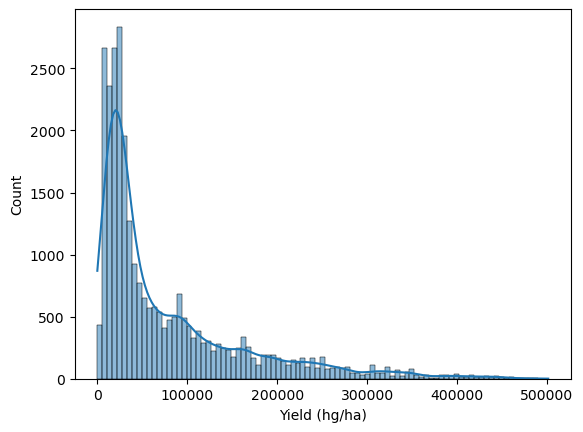

In [283]:
sns.histplot(merged_df['Yield (hg/ha)'], kde=True)

##### We have more yield from range of 10k-20k.  

<Axes: xlabel='Yield (hg/ha)'>

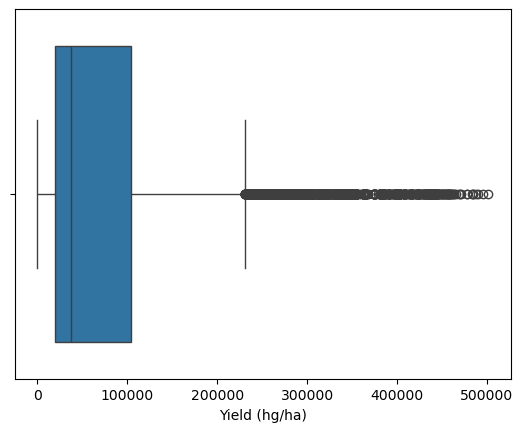

In [68]:
# Detection of outliers
sns.boxplot(x='Yield (hg/ha)', data=merged_df)

##### There are outliers from the range of 30000-50000 yield but we are using Random Tree Forest which is less sensitive to outliers so keeping them

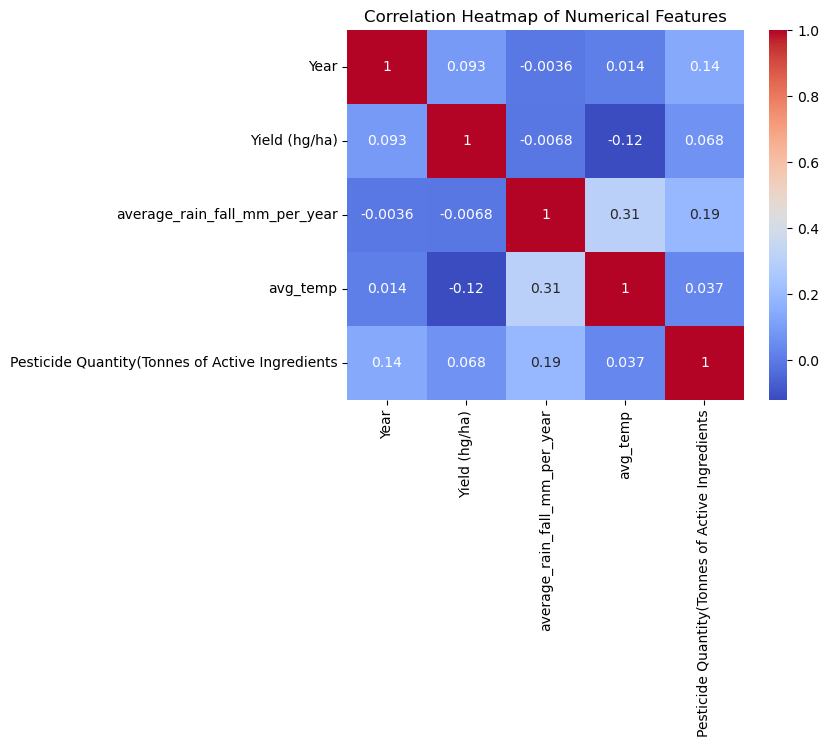

In [76]:
# Checking correlation among features
numeric_df = merged_df.select_dtypes(include=['number'])

# Plot heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

##### The correlation values all around 0 shows no correlation among features

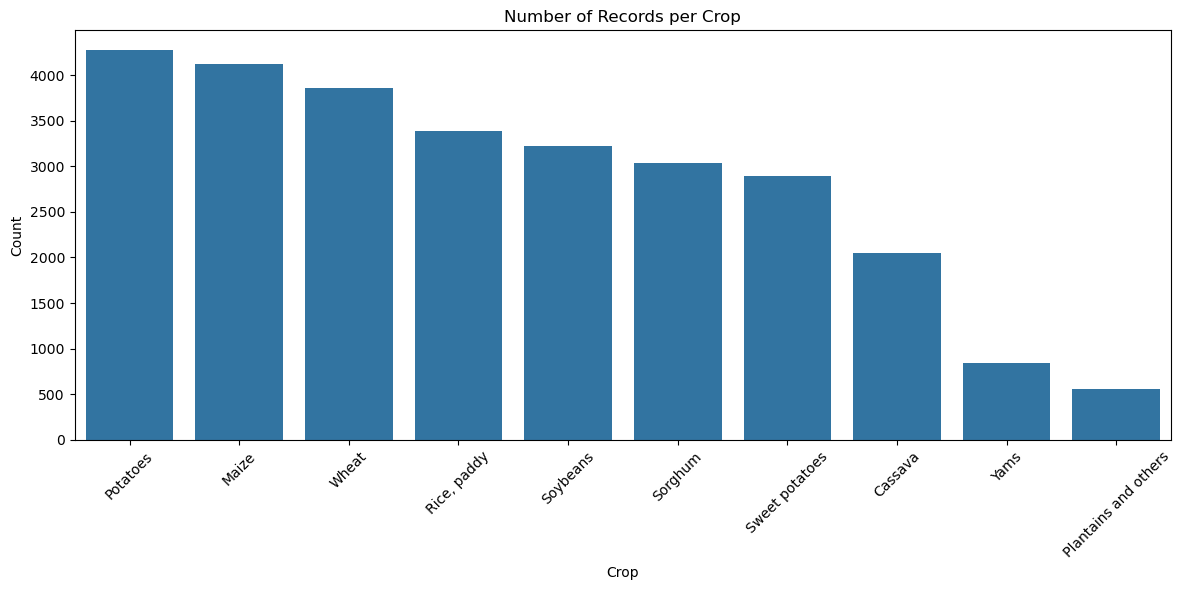

In [55]:
# Analysis on what types of crops we have
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df, x='Item', order=merged_df['Item'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Number of Records per Crop')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Crop Rice and Paddy maybe the same crop so renaming Paddy.
"Plantains and others" are vague crops that may not be useful so dropping it

In [62]:
merged_df['Item'] = merged_df['Item'].str.replace('paddy','Rice')
merged_df = merged_df[merged_df['Item'] != 'Plantains and others']

In [63]:
merged_df['Item'].value_counts()

Item
Potatoes          4276
Maize             4123
Wheat             3857
Rice, Rice        3388
Soybeans          3223
Sorghum           3039
Sweet potatoes    2892
Cassava           2047
Yams               847
Name: count, dtype: int64

<Axes: xlabel='pesticides', ylabel='Count'>

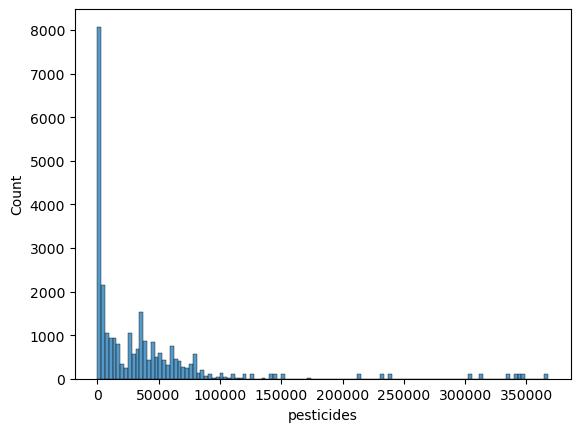

In [158]:
### Checking the pesticide usage data

## Checking the data distribution in the yield column
sns.histplot(merged_df, x = 'pesticides' )

No pesticide use has a high count. This can add a bias in the target variable. So removing outliers from the 'pesticides' column in the merged_df DataFrame by keeping only the values that are less than or equal to the 90th percentile (also called the 0.90 quantile).

In [159]:
merged_df = merged_df[merged_df['pesticides'] <= merged_df['pesticides'].quantile(0.90)]

<Axes: xlabel='Yield (hg/ha)', ylabel='Count'>

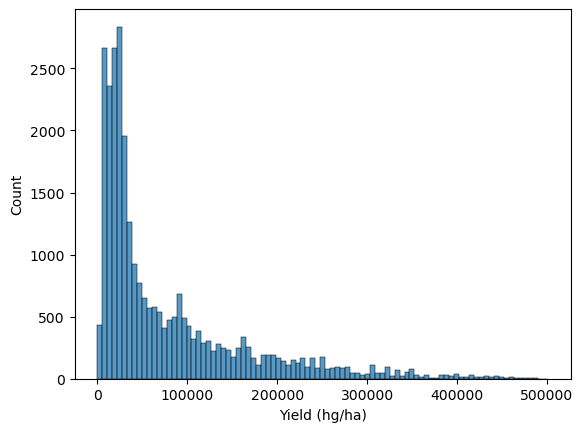

In [271]:
sns.histplot(merged_df, x = 'Yield (hg/ha)' )

The results show it didn't create issue for the data. So removing more outliers by keeping 95 % of data and removing the 5 % again

In [160]:
merged_df = merged_df[merged_df['pesticides'] <= merged_df['pesticides'].quantile(0.95)]

### Explanation of Feature Engineering, algorithm and Model Selection
Our Goal is to classify whether yield in a given season will be below-average, average, or above-average. We are using Classification algorithm. We need Classes of yield **"Low, average, high"**. The yield feature is a numerical variable and continuous. In feature Enggineering step, we convert it into categorical feature

### Feature-Target Split
- X ( input features ) -> Rainfall, Temperture, Pesticides
- Y ( Target Feature ) -> Yield

In [286]:
# Feature Engineering:
def yield_category(y):
    if y < merged_df['Yield (hg/ha)'].quantile(0.33):
        return 'Low'
    elif y < merged_df['Yield (hg/ha)'].quantile(0.66):
        return 'Medium'
    else:
        return 'High'

merged_df['Yield_Class'] = merged_df['Yield (hg/ha)'].apply(yield_category)

#### Distribution of Classes

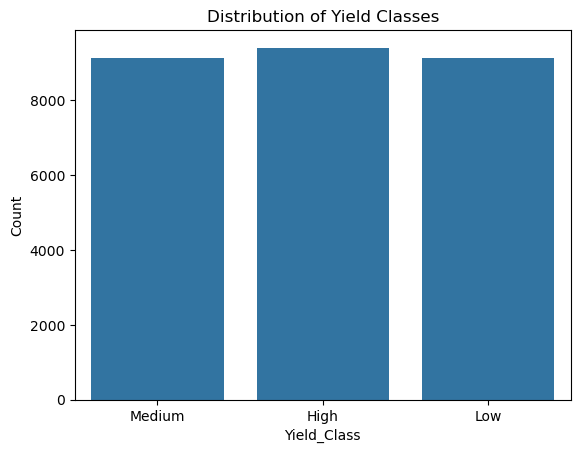

In [126]:
sns.countplot(x='Yield_Class', data=merged_df)
plt.title('Distribution of Yield Classes')
plt.xlabel('Yield_Class')
plt.ylabel('Count')
plt.show()

ALL THREE CLASSES ARE HIGHLY BALANCED.

In [287]:
merged_df.tail()

,Area,Year,Item,Yield (hg/ha),average_rain_fall_mm_per_year,avg_temp,Pesticide Quantity(Tonnes of Active Ingredients,Yield_Class
28243,Zimbabwe,2009,Wheat,30000,657.0,20.52,3269.99,Medium
28244,Zimbabwe,2010,Wheat,27681,657.0,21.17,3305.17,Medium
28245,Zimbabwe,2011,Wheat,26274,657.0,20.78,3340.35,Medium
28246,Zimbabwe,2012,Wheat,24420,657.0,20.52,3375.53,Low
28247,Zimbabwe,2013,Wheat,22888,657.0,19.76,2550.07,Low


In [288]:
# Renaming input features for better ease of use
merged_df = merged_df.rename(columns={'average_rain_fall_mm_per_year':'rainfall','Pesticide Quantity(Tonnes of Active Ingredients':'pesticides','avg_temp':'temperature'})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           28248 non-null  object 
 1   Year           28248 non-null  int64  
 2   Item           28248 non-null  object 
 3   Yield (hg/ha)  28248 non-null  int64  
 4   rainfall       28242 non-null  float64
 5   temperature    28248 non-null  float64
 6   pesticides     28248 non-null  float64
 7   Yield_Class    28248 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.7+ MB


In [84]:
# Feature-Target split
X = merged_df[['rainfall', 'temperature', 'pesticides']]
y = merged_df['Yield_Class']

In [157]:
merged_df.groupby(['Area','Item'], sort=True)['Yield (hg/ha)'].sum().nlargest(10)

Area            Item          
India           Cassava           142810624
                Potatoes           92122514
Brazil          Potatoes           49602168
United Kingdom  Potatoes           46705145
Australia       Potatoes           45670386
India           Sweet potatoes     44439538
Japan           Potatoes           42918726
Mexico          Potatoes           42053880
                Sweet potatoes     35808592
Australia       Sweet potatoes     35550294
Name: Yield (hg/ha), dtype: int64

## Model Building 

#### Train-test split
- test_size(0.2) tells 20% data for testing, 80% for training
- random state(42) ensures consistent data splitting

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

##### We do not need features standardiztion because Random forest model is based on Based on threshold-based splits, not distance

#### Random Forest Classification

In [295]:
merged_df.size

225936

for Medium to large dataset (e.g. 1000–50,000 rows), estimator = 100 is efficient 

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.25      0.24      0.25      1900
         Low       0.38      0.39      0.38      1859
      Medium       0.30      0.31      0.30      1779

    accuracy                           0.31      5538
   macro avg       0.31      0.31      0.31      5538
weighted avg       0.31      0.31      0.31      5538



#### Model is underperforming until now with the accuracy of ~30%

<Axes: >

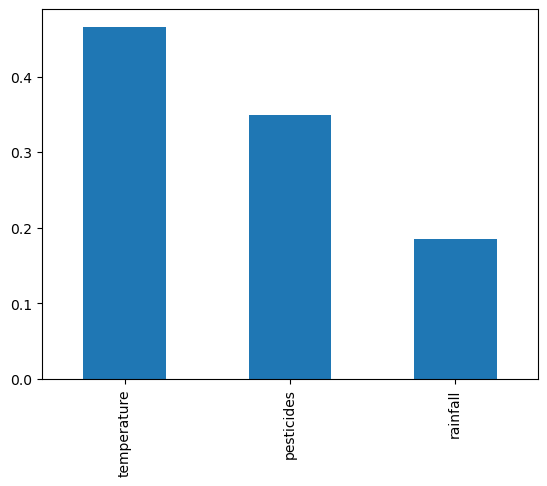

In [115]:
# Checking if the input features are predictive enough
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar')

Temperature and Pesticides are more predictive features accoring to this dataset for yield

In [294]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28247
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           28242 non-null  object 
 1   Year           28242 non-null  int64  
 2   Item           28242 non-null  object 
 3   Yield (hg/ha)  28242 non-null  int64  
 4   rainfall       28242 non-null  float64
 5   temperature    28242 non-null  float64
 6   pesticides     28242 non-null  float64
 7   Yield_Class    28242 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.9+ MB


In [291]:
missing_percent = (merged_df.isnull().sum() / len(merged_df)) * 100
print(missing_percent)

Area             0.0
Year             0.0
Item             0.0
Yield (hg/ha)    0.0
rainfall         0.0
temperature      0.0
pesticides       0.0
Yield_Class      0.0
dtype: float64


#### Using Gradient Boosting Classifier to improve accuracy of classification

In [293]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Albania'

In [120]:
y_pred = model.predict(X_test)

In [132]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.39364391477067534

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.20      0.25      1900
         Low       0.41      0.63      0.50      1859
      Medium       0.40      0.35      0.37      1779

    accuracy                           0.39      5538
   macro avg       0.39      0.39      0.37      5538
weighted avg       0.38      0.39      0.37      5538


Confusion Matrix:
[[ 375  925  600]
 [ 323 1179  357]
 [ 369  784  626]]


#### Accuracy is improved ~39%

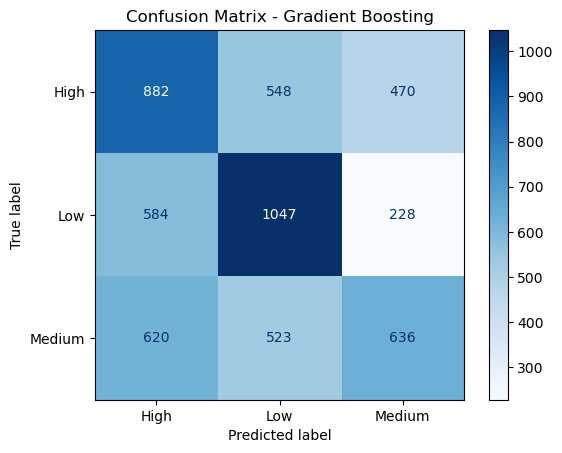

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

In [104]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27686 entries, 0 to 28247
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           27686 non-null  object 
 1   Year           27686 non-null  int64  
 2   Item           27686 non-null  object 
 3   Yield (hg/ha)  27686 non-null  int64  
 4   rainfall       27686 non-null  float64
 5   temperature    27686 non-null  float64
 6   pesticides     27686 non-null  float64
 7   Yield_Class    27686 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.9+ MB


In [112]:
print(X.isnull().sum())
print(X_train.isnull().sum())

rainfall       0
temperature    0
pesticides     0
dtype: int64
rainfall       0
temperature    0
pesticides     0
dtype: int64


##### Even after thorough data cleaning, some NaN values sneaked in that were caught during model training. Cleaning them

In [111]:
X = X.dropna()  
y = y.loc[X.index]

In [128]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.0 MB/s eta 0:02:23
   ---------------------------------------- 0.8/150.0 MB 1.2 MB/s eta 0:02:01
   ---------------------------------------- 1.0/150.0 MB 1.1 MB/s eta 0:02:11
   ---------------------------------------- 1.0/150.0 MB 1.1 MB/s eta 0:02:11
   ---------------------------------------- 1.3/150.0 MB 849.7 kB/s eta 0:02:55
   ---------------------------------------- 1.6/150.0 MB 953.2 kB/s eta 0:02:36
   ---------------------------------------- 1.8/150.0 MB 986.7 kB/s eta 0:02:31
    --------------------------------------- 2.1/150.0 MB 995.1 kB/s eta 0:02:29
    --------------------------------------- 2.1/150.0 MB 995.1 kB/s eta 0:02:29
    --------------------------------------- 2.4/150.0 MB 979.5 kB/s eta 0:0

In [136]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train XGBoost
model = XGBClassifier(
    objective='multi:softmax',  # predicts class labels directly
    num_class=3,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Optional: convert back to string labels
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

In [137]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.466955579631636
              precision    recall  f1-score   support

           0       0.42      0.44      0.43      1883
           1       0.49      0.57      0.52      1826
           2       0.49      0.40      0.44      1829

    accuracy                           0.47      5538
   macro avg       0.47      0.47      0.47      5538
weighted avg       0.47      0.47      0.46      5538

[[ 826  578  479]
 [ 521 1033  272]
 [ 600  502  727]]


##### 46% accuracy with XGB CLassifier

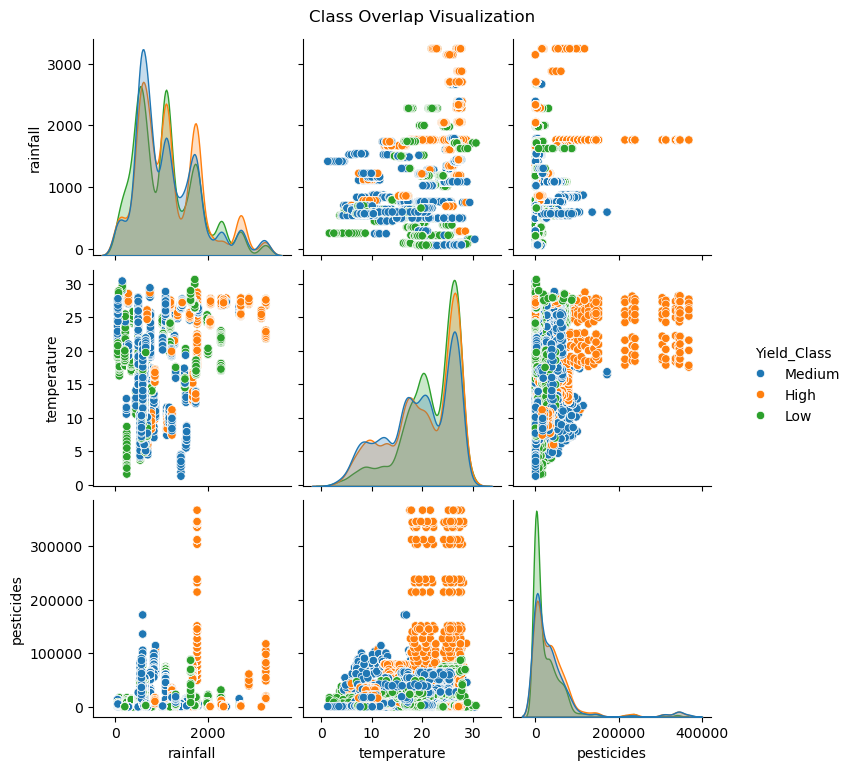

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

X_plot = X.copy()
X_plot['Yield_Class'] = y  # original string labels

sns.pairplot(X_plot, hue='Yield_Class', diag_kind='kde')
plt.suptitle("Class Overlap Visualization", y=1.02)
plt.show()

##### As the classes are highly overlapped, classification models are giving only limited values. To get the actual yield, let's use the regression models.

In [233]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score

In [296]:
merged_data_copy1 = merged_df.copy()

In [299]:
merged_data_copy1.drop('Yield_Class', axis=1, inplace=True)

In [300]:
merged_data_copy1.head()

,Area,Year,Item,Yield (hg/ha),rainfall,temperature,pesticides
0,Albania,1990,Maize,36613,1485.0,16.37,121.0
1,Albania,1991,Maize,29068,1485.0,15.36,121.0
2,Albania,1992,Maize,24876,1485.0,16.06,121.0
3,Albania,1993,Maize,24185,1485.0,16.05,121.0
4,Albania,1994,Maize,25848,1485.0,16.96,201.0


In [265]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Split the dataset early
train_df = merged_data_copy1[merged_data_copy1['Year'] <= 2009].copy()
test_df  = merged_data_copy1[merged_data_copy1['Year'] > 2009].copy()

# 2. Separate features and labels
X_train = train_df.drop(columns=['Yield (hg/ha)', 'Year'], errors='ignore')
y_train = train_df['Yield (hg/ha)']

X_test  = test_df.drop(columns=['Yield (hg/ha)', 'Year'], errors='ignore')
y_test  = test_df['Yield (hg/ha)']

# 3. Define a preprocessing pipeline
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# 4. Final ML pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

# 5. Fit and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 6. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression R²: {r2:.4f}")


Linear Regression MSE: 2677316962.53
Linear Regression R²: 0.7066


E:\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


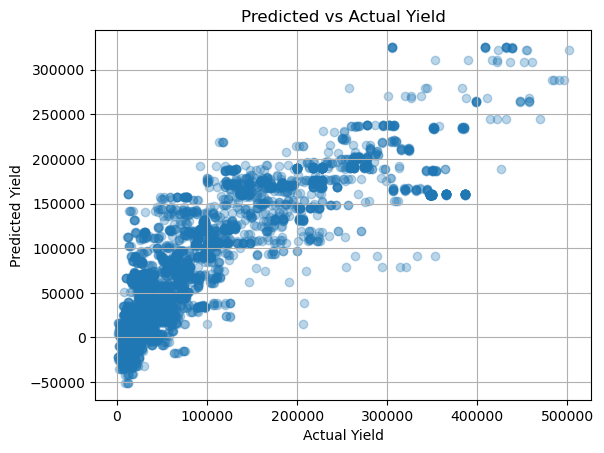

In [264]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield")
plt.grid(True)
plt.show()


#### From the visualization and error scores, we can see model is predicting yield values very well. R2 = 0.7066, closer to 1, 	Good fit — 70%+ variance explained by the model